# Analyze Order Book Data

## Imports & Settings

In [1]:
# %load_ext cudf.pandas
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show
from scipy.stats import normaltest

In [2]:
##%%cudf.pandas.profile
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

In [3]:
##%%cudf.pandas.profile
data_path = Path('/home/rick/Documents/ML4T/data/02_01')
itch_store = str(data_path / 'itch.h5')
order_book_store = str(data_path / 'order_book.h5')
stock = 'TSLA'
date = '20200130'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

## Load system event data

In [4]:
##%%cudf.pandas.profile
with pd.HDFStore(itch_store) as store:
    sys_events = store['S'].set_index('event_code').drop_duplicates()
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

## Trade Summary

We will combine the messages that refer to actual trades to learn about the volumes for each asset.

In [5]:
#%%cudf.pandas.profile
with pd.HDFStore(itch_store) as store:
    stocks = store['R']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26748 entries, 0 to 8915
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   stock_locate                    26748 non-null  int64          
 1   tracking_number                 26748 non-null  int64          
 2   timestamp                       26748 non-null  timedelta64[ns]
 3   stock                           26748 non-null  object         
 4   market_category                 26748 non-null  object         
 5   financial_status_indicator      26748 non-null  object         
 6   round_lot_size                  26748 non-null  int64          
 7   round_lots_only                 26748 non-null  object         
 8   issue_classification            26748 non-null  object         
 9   issue_sub_type                  26748 non-null  object         
 10  authenticity                    26748 non-null  object         


As expected, a small number of the over 8,500 equity securities traded on this day account for most trades

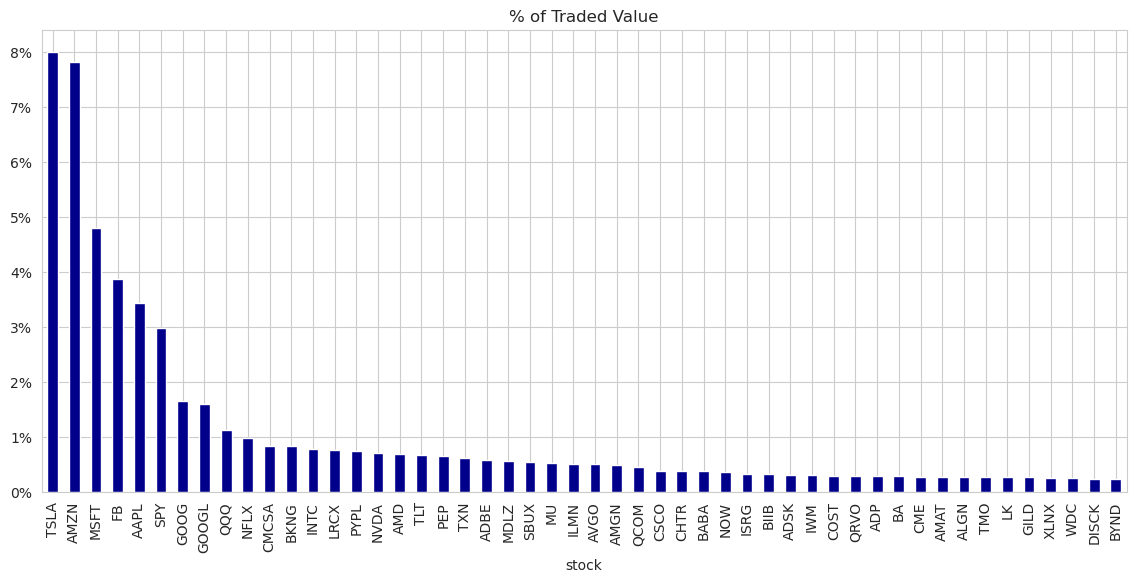

In [7]:
#%%cudf.pandas.profile
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    #trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)
    # Replace append with pd.concat
    trades = pd.concat([store['P'], store['Q'].rename(columns={'cross_price': 'price'})], sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)    
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='% of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

## AAPL Trade Summary

In [ ]:
#%%cudf.pandas.profile
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

In [ ]:
#%%cudf.pandas.profile
trades.price = trades.price.mul(1e-4) # format price
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

## Tick Bars

The trade data is indexed by nanoseconds and is very noisy. The bid-ask bounce, for instance, causes the price to oscillate between the bid and ask prices when trade initiation alternates between buy and sell market orders. To improve the noise-signal ratio and improve the statistical properties, we need to resample and regularize the tick data by aggregating the trading activity.

We typically collect the open (first), low, high, and closing (last) price for the aggregated period, alongside the volume-weighted average price (VWAP), the number of shares traded, and the timestamp associated with the data.

In [ ]:
#%%cudf.pandas.profile
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time
tick_bars.price.plot(figsize=(10, 5), 
                     title='Tick Bars | {} | {}'.format(stock, pd.to_datetime(date).date()), lw=1)
plt.xlabel('')
plt.tight_layout();

### Test for Normality of tick returns

In [ ]:
#%%cudf.pandas.profile
normaltest(tick_bars.price.pct_change().dropna())

## Regularizing Tick Data

### Price-Volume Chart

We will use the `price_volume` function to compare the price-volume relation for various regularization methods.

In [ ]:
#%%cudf.pandas.profile
def price_volume(df, price='vwap', vol='vol', suptitle=title, fname=None):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(5*len(df.index)), color='r')
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Price', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9);

### Time Bars

Time bars involve trade aggregation by period.

In [ ]:
#%%cudf.pandas.profile
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)

We create time bars using the `.resample()` method with the desired period.

In [ ]:
#%%cudf.pandas.profile
resampled = trades.groupby(pd.Grouper(freq='1Min'))
time_bars = get_bar_stats(resampled)
normaltest(time_bars.vwap.pct_change().dropna())

In [ ]:
#%%cudf.pandas.profile
price_volume(time_bars, 
             suptitle=f'Time Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='time_bars')

### Bokeh Candlestick Chart

Alternative visualization using the the [bokeh](https://bokeh.pydata.org/en/latest/) library:

In [ ]:
#%%cudf.pandas.profile
resampled = trades.groupby(pd.Grouper(freq='5Min')) # 5 Min bars for better print
df = get_bar_stats(resampled)

increase = df.close > df.open
decrease = df.open > df.close
w = 2.5 * 60 * 1000 # 2.5 min in ms

WIDGETS = "pan, wheel_zoom, box_zoom, reset, save"

p = figure(x_axis_type='datetime', tools=WIDGETS, plot_width=1500, title = "AAPL Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.4

p.segment(df.index, df.high, df.index, df.low, color="black")
p.vbar(df.index[increase], w, df.open[increase], df.close[increase], fill_color="#D5E1DD", line_color="black")
p.vbar(df.index[decrease], w, df.open[decrease], df.close[decrease], fill_color="#F2583E", line_color="black")
show(p)

### Volume Bars

Time bars smooth some of the noise contained in the raw tick data but may fail to account for the fragmentation of orders. Execution-focused algorithmic trading may aim to match the volume weighted average price (VWAP) over a given period, and will divide a single order into multiple trades and place orders according to historical patterns. Time bars would treat the same order differently, even though no new information has arrived in the market.

Volume bars offer an alternative by aggregating trade data according to volume. We can accomplish this as follows:

In [ ]:
#%%cudf.pandas.profile
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

In [ ]:
#%%cudf.pandas.profile
trades_per_min = trades.shares.sum()/(60*7.5) # min per trading day
trades['cumul_vol'] = trades.shares.cumsum()

In [ ]:
#%%cudf.pandas.profile
f = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)
vol_bars.head()

In [ ]:
#%%cudf.pandas.profile
price_volume(vol_bars.set_index('timestamp'), 
             suptitle=f'Volume Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='volume_bars')

In [ ]:
normaltest(vol_bars.vwap.dropna())

### Dollar Bars

In [ ]:
#%%cudf.pandas.profile
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

In [ ]:
#%%cudf.pandas.profile
value_per_min = trades.shares.mul(trades.price).sum()/(60*7.5) # min per trading day
trades['cumul_val'] = trades.shares.mul(trades.price).cumsum()

In [ ]:
#%%cudf.pandas.profile
df = trades.reset_index()
by_value = df.groupby(df.cumul_val.div(value_per_min).round().astype(int))
dollar_bars = pd.concat([by_value.timestamp.last().to_frame('timestamp'), get_bar_stats(by_value)], axis=1)
dollar_bars.head()

In [ ]:
#%%cudf.pandas.profile
price_volume(dollar_bars.set_index('timestamp'), 
             suptitle=f'Dollar Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='dollar_bars')